<a href="https://colab.research.google.com/github/Carlos1729/Transformers_Code/blob/main/behind_the_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Behind the pipeline (PyTorch)

Install the Transformers, Datasets, and Evaluate libraries to run this notebook.

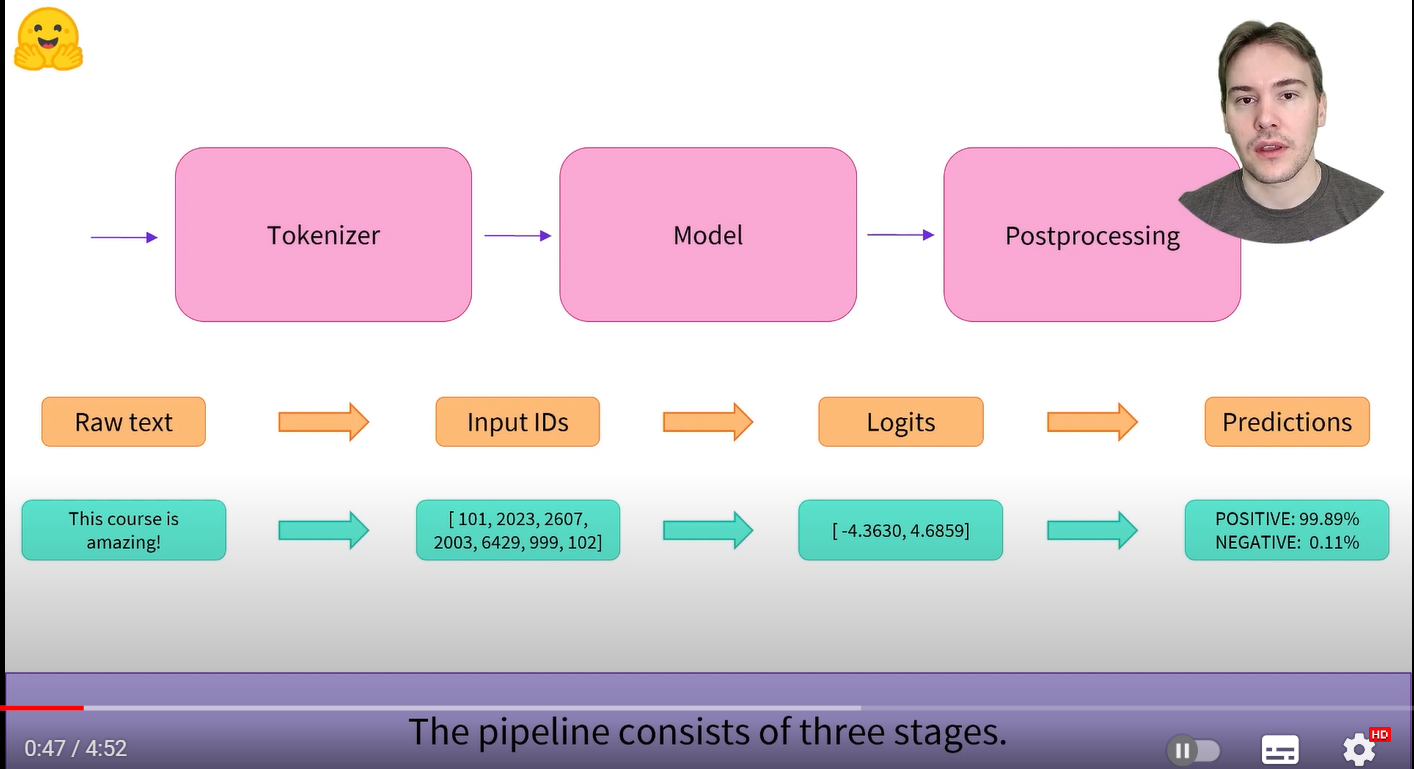

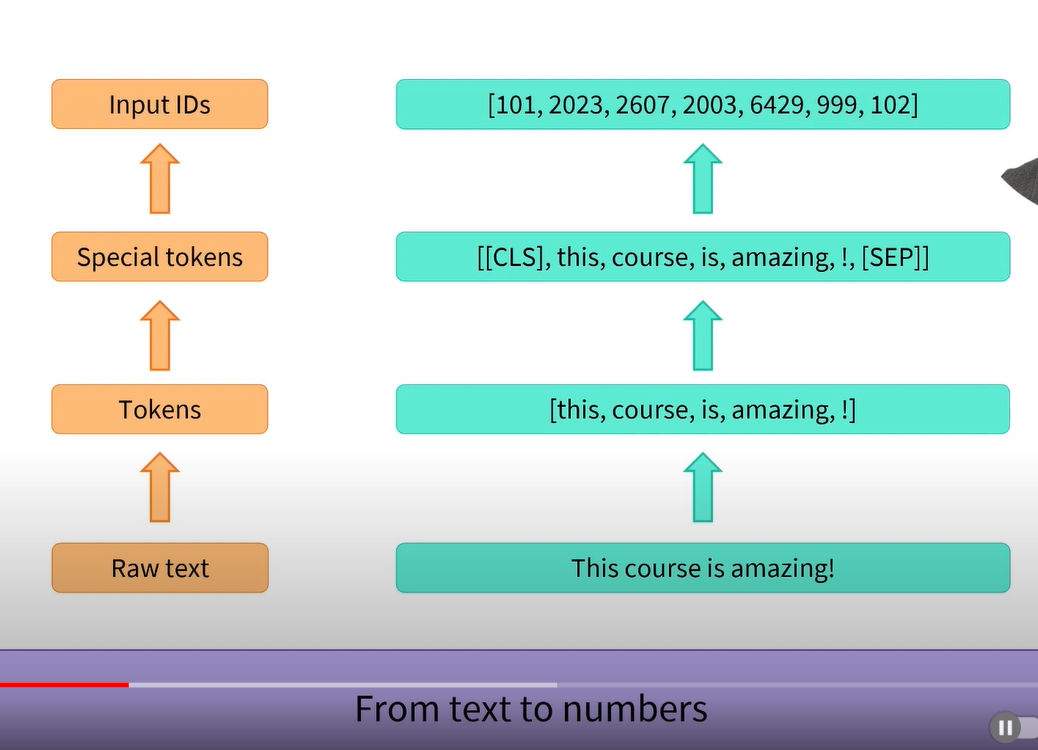

In [4]:
# tokenizer, which will be responsible for:

# Splitting the input into words, subwords, or symbols (like punctuation) that are called tokens
# Mapping each token to an integer
# Adding additional inputs that may be useful to the model

# Preprocessing with a tokenizer bhas to be done in exactly the same way as when the model was pretrained,

In [3]:
!pip install datasets evaluate transformers[sentencepiece]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 12.2 MB/s eta 0:00:00


In [5]:
from transformers import pipeline

classifier = pipeline("sentiment-analysis")
classifier(
    [
        "I've been waiting for a HuggingFace course my whole life.",
        "I hate this so much!",
    ]
)

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

[{'label': 'POSITIVE', 'score': 0.9598048329353333},
 {'label': 'NEGATIVE', 'score': 0.9994558691978455}]

In [7]:
from transformers import AutoTokenizer

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

# Using the checkpoint name of our model, it will automatically fetch the data associated with the model’s tokenizer and cache it
#  (so it’s only downloaded the first time you run the code below).
# default checkpoint of the sentiment-analysis pipeline is distilbert-base-uncased-finetuned-sst-2-english
# Once we have the tokenizer, we can directly pass our sentences to it and we’ll get back a dictionary that’s ready to feed to our model!
# The only thing left to do is to convert the list of input IDs to tensors.

In [8]:
raw_inputs = [
    "I've been waiting for a HuggingFace course my whole life.",
    "I hate this so much!",
]
inputs = tokenizer(raw_inputs, padding=True, truncation=True, return_tensors="pt")#pt here means it is a pytorch tensor
print(inputs)
# input_ids contains two rows of integers (one for each sentence) that are the unique identifiers of the tokens in each sentence

{'input_ids': tensor([[  101,  1045,  1005,  2310,  2042,  3403,  2005,  1037, 17662, 12172,
          2607,  2026,  2878,  2166,  1012,   102],
        [  101,  1045,  5223,  2023,  2061,  2172,   999,   102,     0,     0,
             0,     0,     0,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]])}


In [9]:
from transformers import AutoModel
# We can download our pretrained model the same way we did with our tokenizer.

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
model = AutoModel.from_pretrained(checkpoint)
# This architecture contains only the base Transformer module: given some inputs, it outputs what we’ll call hidden states, also known as features.
# For each model input, we’ll retrieve a high-dimensional vector representing the contextual understanding of that input by the Transformer model.

# While these hidden states can be useful on their own, they’re usually inputs to another part of the model, known as the head.
# In Chapter 1, the different tasks could have been performed with the same architecture, but each of these tasks will have a different head associated with it.

In [ ]:
outputs = model(**inputs)
print(outputs.last_hidden_state.shape)
# A high-dimensional vector?
# The vector output by the Transformer module is usually large. It generally has three dimensions:

# Batch size: The number of sequences processed at a time (2 in our example).
# Sequence length: The length of the numerical representation of the sequence (16 in our example).
# Hidden size: The vector dimension of each model input.
# It is said to be “high dimensional” because of the last value. The hidden size can be very large (768 is common for smaller models, and in larger models this can reach 3072 or more)

torch.Size([2, 16, 768])

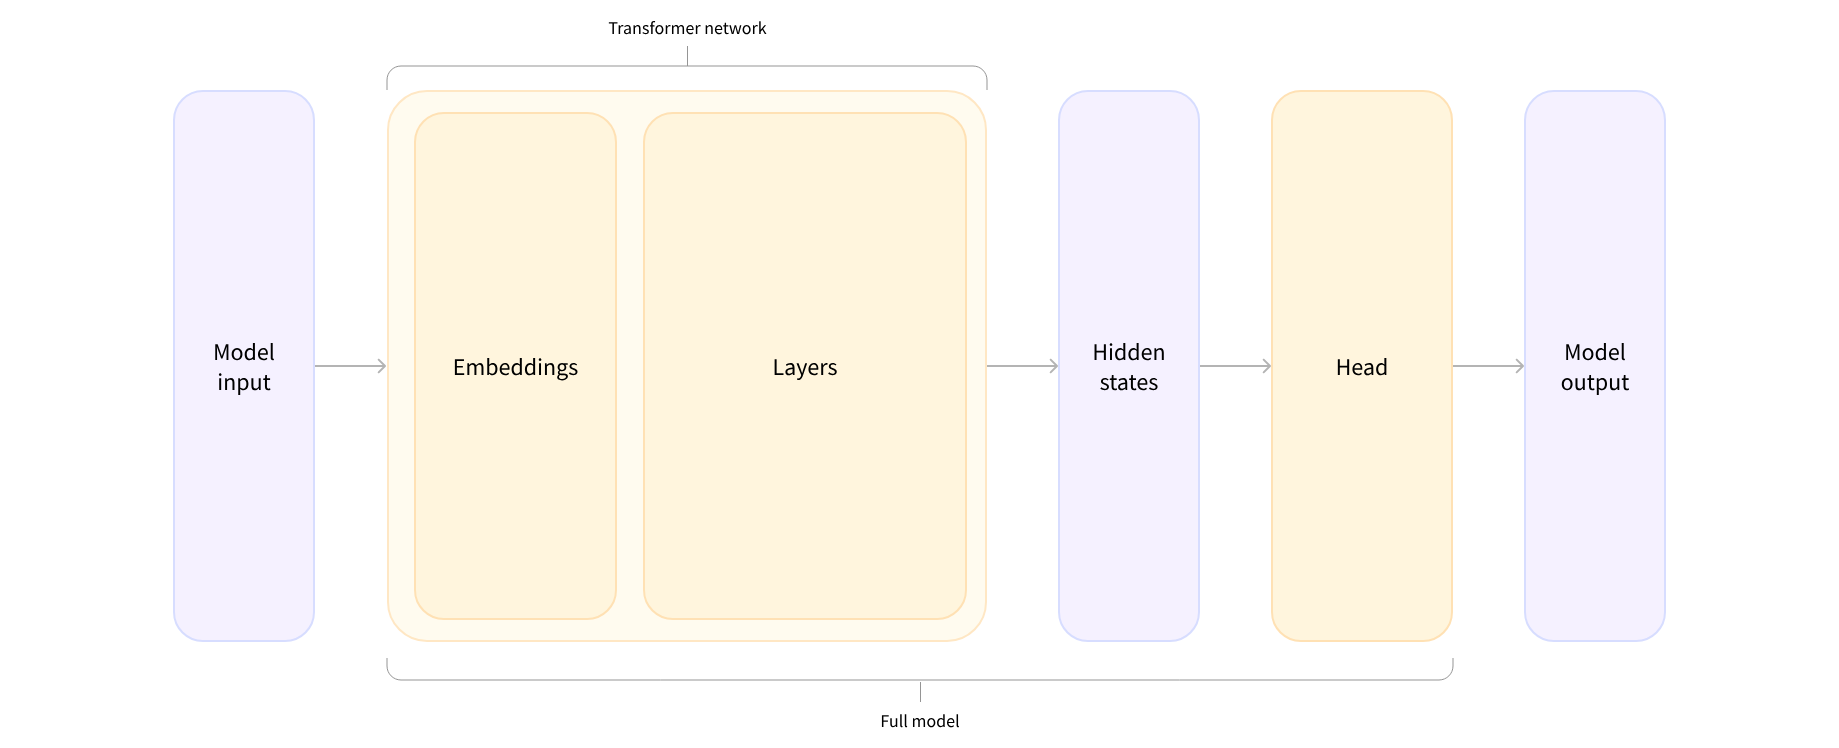

In [ ]:
# , the model is represented by its embeddings layer and the subsequent layers. The embeddings layer converts each input ID in the tokenized input
# into a vector that represents the associated token. The subsequent layers manipulate those vectors using the attention mechanism to produce the
# final representation of the sentences.

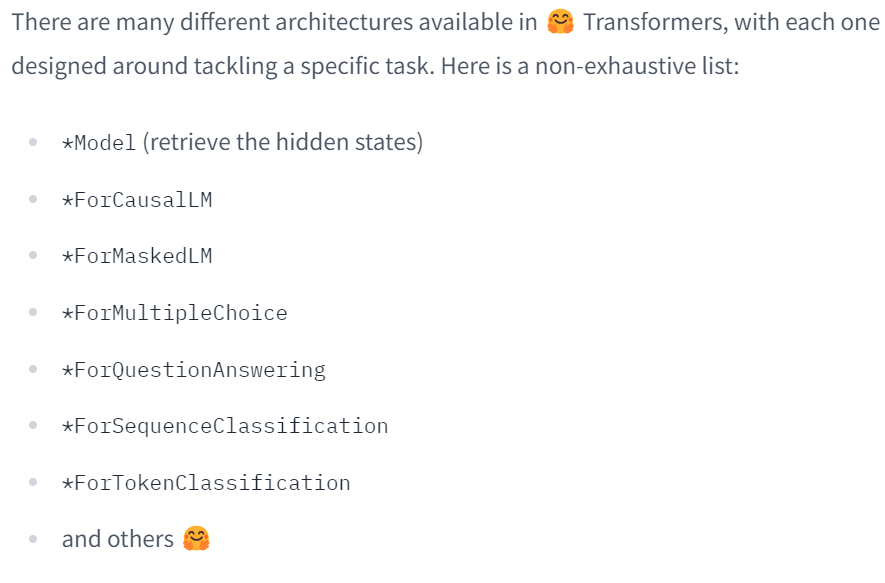

In [10]:
from transformers import AutoModelForSequenceClassification

# For our example, we will need a model with a sequence classification head (to be able to classify the sentences as positive or negative).
# So, we won’t actually use the AutoModel class, but AutoModelForSequenceClassification:

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)
outputs = model(**inputs)

In [11]:
print(outputs.logits.shape)
# Now if we look at the shape of our outputs, the dimensionality will be much lower: the model head takes as input the high-dimensional vectors
#  we saw before, and outputs vectors containing two values (one per label):

torch.Size([2, 2])


In [12]:
print(outputs.logits)

tensor([[-1.5607,  1.6123],
        [ 4.1692, -3.3464]], grad_fn=<AddmmBackward0>)


In [13]:
import torch

predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
print(predictions)
# Those are not probabilities but logits, the raw, unnormalized scores outputted by the last layer of the model.
# To be converted to probabilities, they need to go through a SoftMax layer (all 🤗 Transformers models output the logits, as the loss
# function for training will generally fuse the last activation function, such as SoftMax, with the actual loss function, such as cross entropy):

tensor([[4.0195e-02, 9.5980e-01],
        [9.9946e-01, 5.4418e-04]], grad_fn=<SoftmaxBackward0>)


In [16]:
# Now we can conclude that the model predicted the following:

# First sentence: NEGATIVE: 0.0402, POSITIVE: 0.9598
# Second sentence: NEGATIVE: 0.9995, POSITIVE: 0.0005
# We have successfully reproduced the three steps of the pipeline: preprocessing with tokenizers, passing the inputs through the model, and postprocessing! Now let’s take some time to dive deeper into each of those steps.

In [15]:
model.config.id2label
# To get the labels corresponding to each position, we can inspect the id2label attribute of the model config (more on this in the next section):

{0: 'NEGATIVE', 1: 'POSITIVE'}